In [8]:
cd ..

/home/mushahid/Desktop/project/cpenprojec/UnsupGenModbyMPS


In [9]:
%load_ext autoreload

import matplotlib.pyplot as plt
import numpy as np
import pennylane as qml
from pennylane import numpy as pnp
import jax.numpy as jnp
import optax
import jax
import mps_circuit_helpers
import mps_circuit
import metrics

from jax.config import config
config.update("jax_enable_x64", True)
from MPScumulant import MPS_c


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load and visualize the dataset

(30, 4, 4) bool


(<Figure size 1800x1500 with 30 Axes>, <Axes: >)

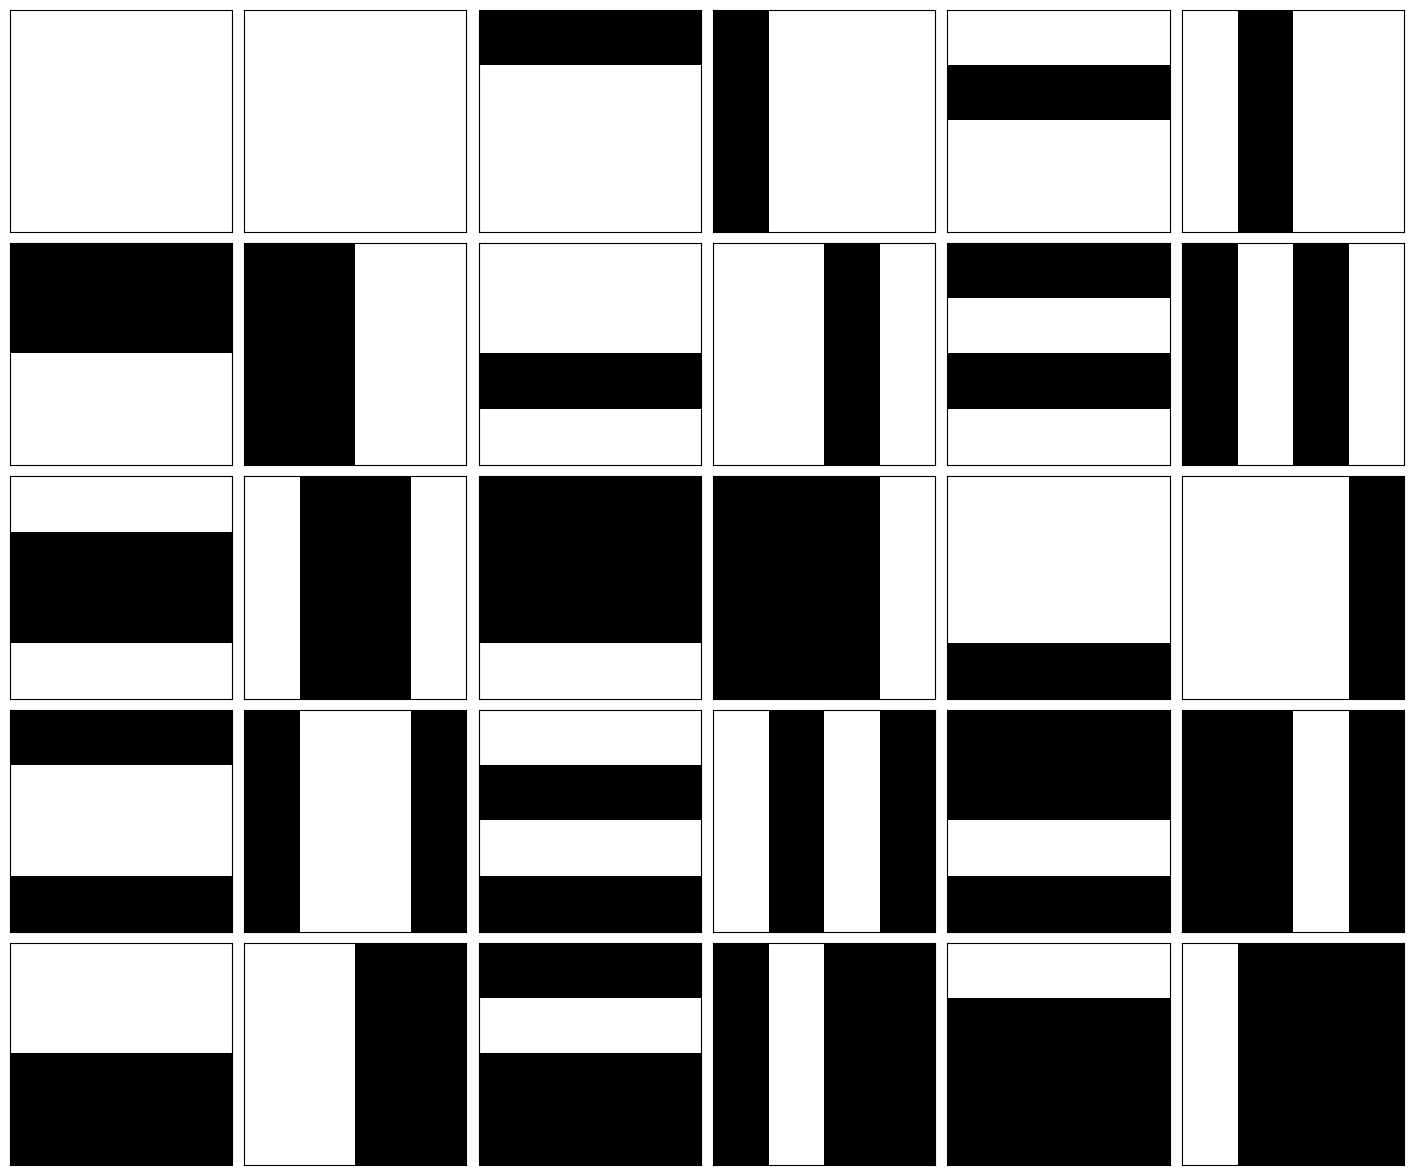

In [3]:
%autoreload
data = np.load('BStest/BSdata.npy')
print(data.shape, data.dtype)

# convert bool data to int
data = data.astype(np.int32)

metrics.plot_BAS(data)

# Load the trained MPS

In [21]:
%autoreload
m = MPS_c(16, max_bond_dim=300)
m.loadMPS('BS-MPS')

# check the properties of the matrices in the MPS
print("core tensor index, shape")
for i in range(len(m.matrices)):
    tn_core = m.matrices[i]
    print(i, tn_core.shape)

core tensor index, shape
0 (1, 2, 2)
1 (2, 2, 4)
2 (4, 2, 8)
3 (8, 2, 15)
4 (15, 2, 16)
5 (16, 2, 16)
6 (16, 2, 16)
7 (16, 2, 15)
8 (15, 2, 16)
9 (16, 2, 16)
10 (16, 2, 16)
11 (16, 2, 15)
12 (15, 2, 8)
13 (8, 2, 4)
14 (4, 2, 2)
15 (2, 2, 1)


![mps.png](../figures/trained-mps.png)

## Check the normalization of the MPS

In [22]:
mps_circuit_helpers.are_isometries(m)

idx, core tensor shape, left isometry, right isometry
0 (1, 2, 2) True True
1 (2, 2, 4) True True
2 (4, 2, 8) True True
3 (8, 2, 15) True False
4 (15, 2, 16) True False
5 (16, 2, 16) True False
6 (16, 2, 16) True False
7 (16, 2, 15) True False
8 (15, 2, 16) True False
9 (16, 2, 16) True False
10 (16, 2, 16) True False
11 (16, 2, 15) True False
12 (15, 2, 8) True False
13 (8, 2, 4) True False
14 (4, 2, 2) False False
15 (2, 2, 1) False False


We can see that some of the tensors are already isometries but not all.

In [23]:
%autoreload
mps_unitaries = mps_circuit_helpers.get_mps_unitaries(m)

padding the mps core tensors
idx, shape of the padded tensor, updated bond dimension
i = 1, (2, 2, 4), 2
i = 2, (4, 2, 8), 4
i = 3, (8, 2, 16), 8
i = 4, (16, 2, 16), 16
i = 5, (16, 2, 16), 16
i = 6, (16, 2, 16), 16
i = 7, (16, 2, 16), 16
i = 8, (16, 2, 16), 16
i = 9, (16, 2, 16), 16
i = 10, (16, 2, 16), 16
i = 11, (16, 2, 16), 16
i = 12, (16, 2, 8), 16
i = 13, (8, 2, 4), 8
i = 14, (4, 2, 2), 4
left canonicalizing the padded MPS
bond: 0
bond: 1
bond: 2
bond: 3
bond: 4
bond: 5
bond: 6
bond: 7
bond: 8
bond: 9
bond: 10
bond: 11
bond: 12
bond: 13
bond: 14


In [24]:
print(f"Total no. of multi-qubit unitaries {len(mps_unitaries)}")

Total no. of multi-qubit unitaries 15


# Create the MPS-to-PQC quantum circuit

(<Figure size 1800x1700 with 1 Axes>, <Axes: >)

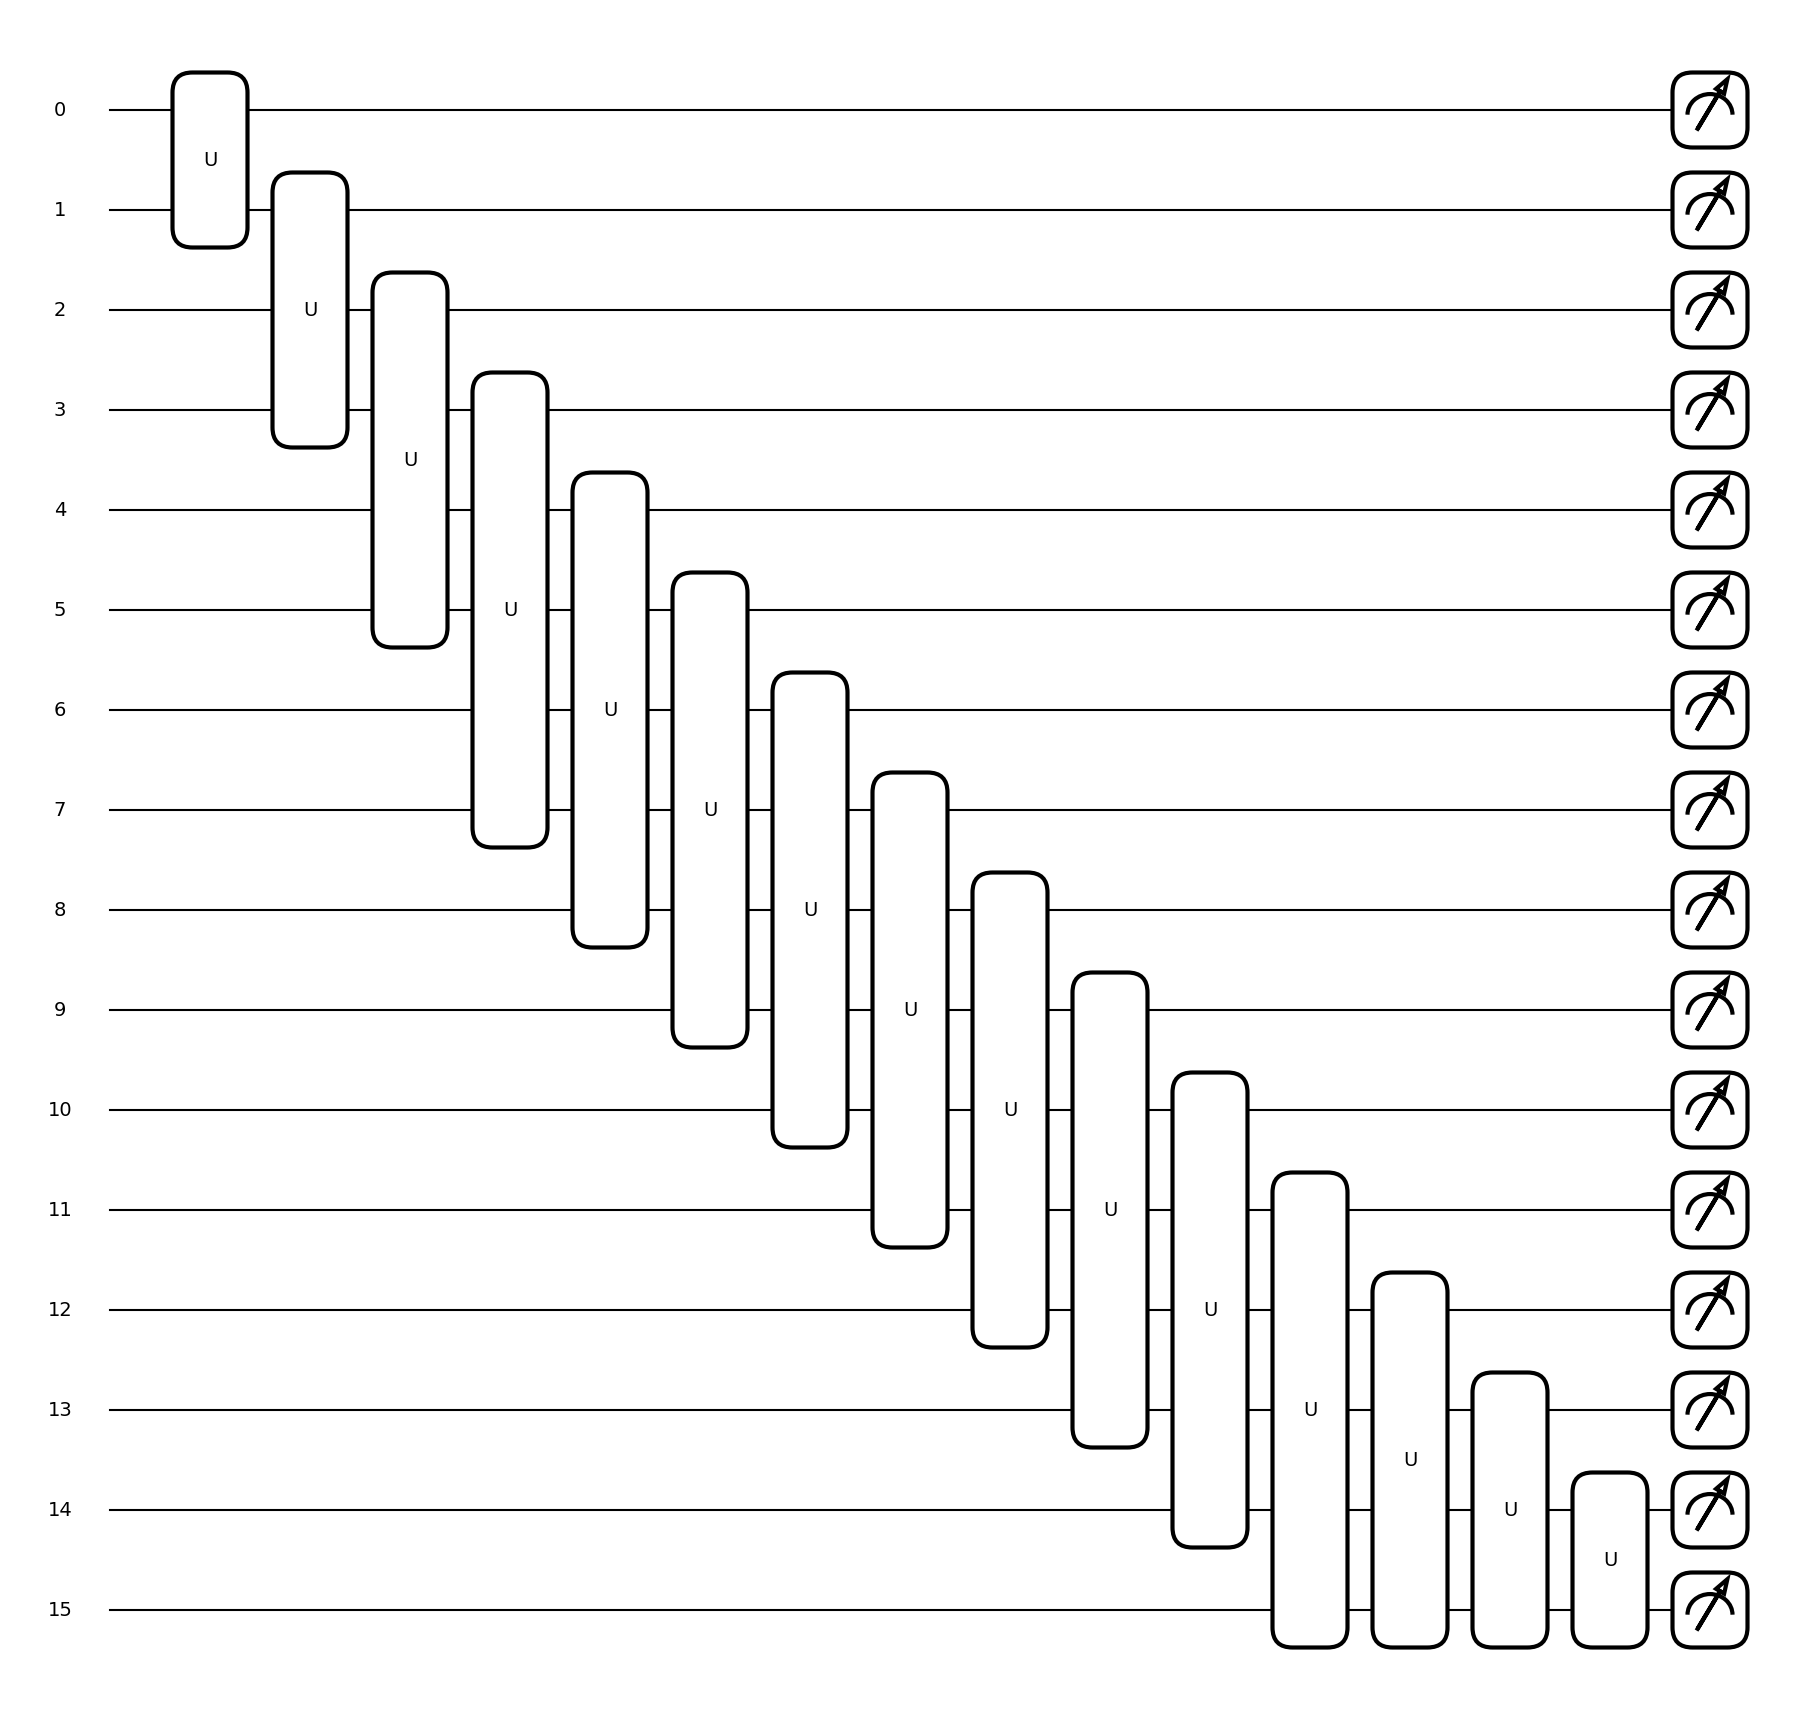

In [25]:
%autoreload
circuit = mps_circuit.mps_unitaries_to_circuit(mps_unitaries)
qml.drawer.draw_mpl(circuit)()

## Evaluate KL-divergence of the trained model

In [26]:
probs = circuit()
kl_div = metrics.kl_divergence(probs, data)
print(kl_div)

27.702831373582278


## Generate and visualize samples from the circuit

In [27]:
sampling_circuit = mps_circuit.mps_unitaries_to_circuit(mps_unitaries,
                                                        shots=10000)
samples = sampling_circuit()

## Plot the top-30 most frequent BAS samples generated by the model

Frequency : 22
Frequency : 21
Frequency : 19
Frequency : 16
Frequency : 16
Frequency : 15
Frequency : 14
Frequency : 14
Frequency : 14
Frequency : 14
Frequency : 14
Frequency : 13
Frequency : 13
Frequency : 13
Frequency : 13
Frequency : 13
Frequency : 12
Frequency : 12
Frequency : 12
Frequency : 12
Frequency : 12
Frequency : 11
Frequency : 11
Frequency : 11
Frequency : 11
Frequency : 11
Frequency : 11
Frequency : 11
Frequency : 11
Frequency : 11


(<Figure size 1800x1500 with 30 Axes>, <Axes: >)

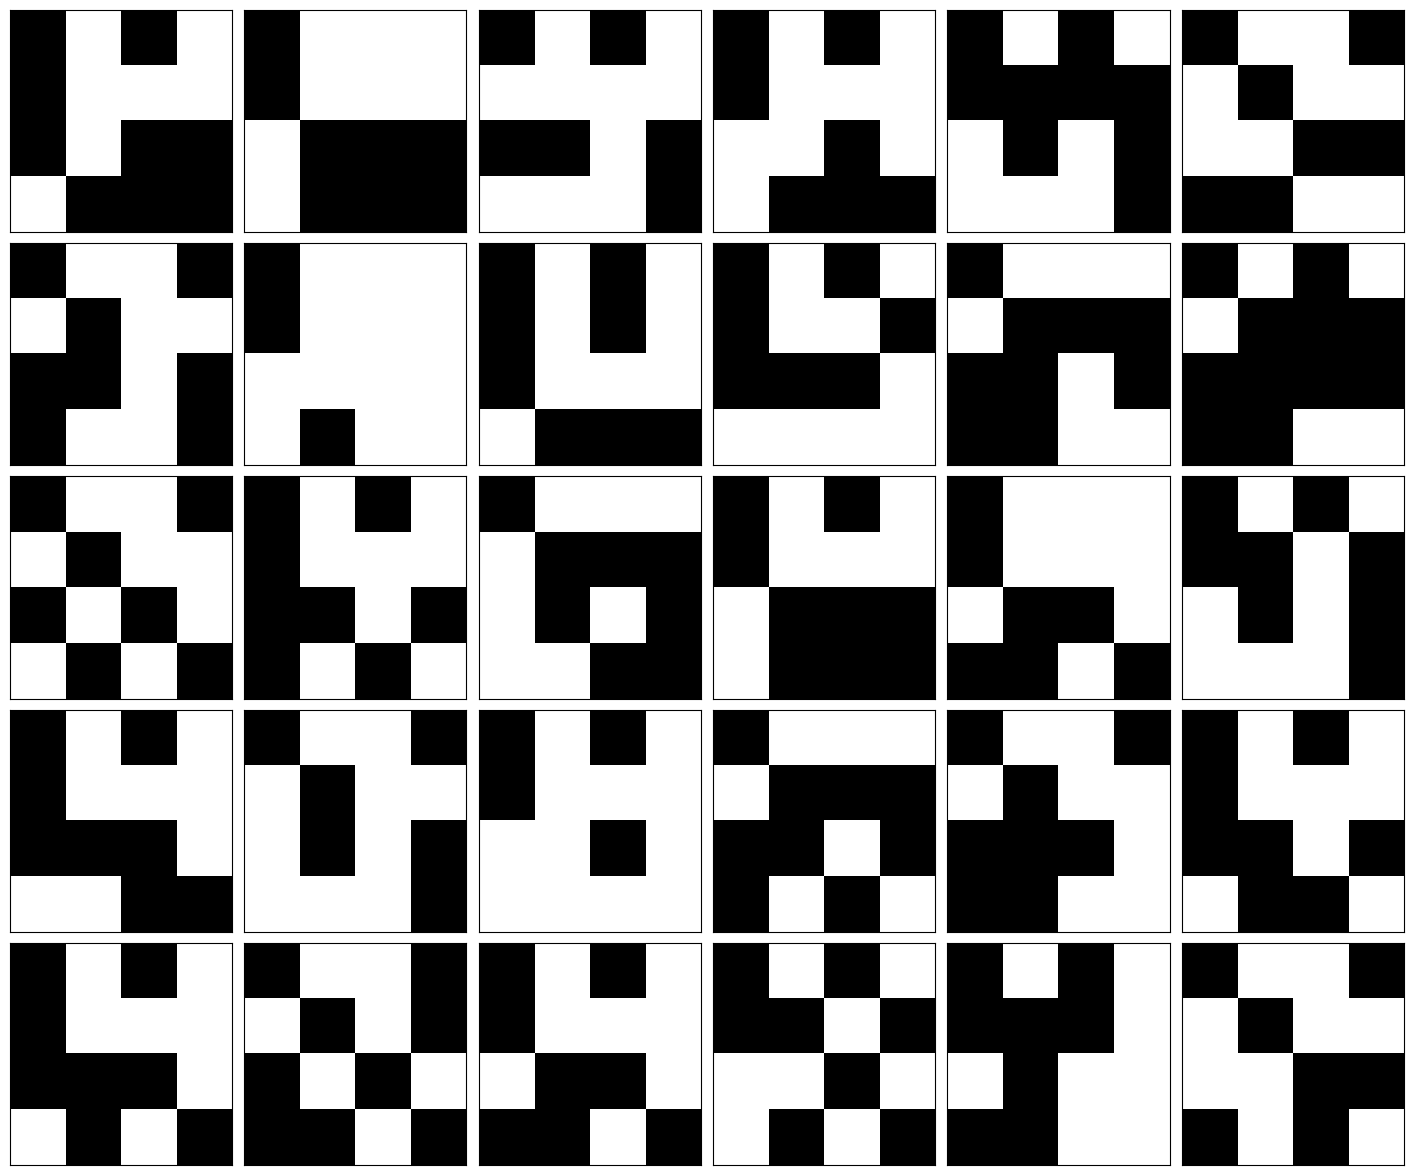

In [28]:
%autoreload
metrics.plot_top_samples(samples)

## Extend the MPS circuit with trainable parameters

In [29]:
n_qubits = 5
n_wires = 16
wire = 1
u_wires = [wire] + list(range(wire+1, wire+n_qubits))
n_wires = len(mps_unitaries) + 1
weights = jnp.array(pnp.random.normal(size=(45, 1), requires_grad=True))
shots = None
dev = qml.device("default.qubit", wires=n_wires, shots=shots)

@qml.qnode(dev, interface="jax")
def pqc_circuit(weights):

    for wire in range(n_wires-1):
        unitary = mps_unitaries[wire]
        n_qubits = int(np.log2(unitary.shape[0]))
        u_wires = [wire] + list(range(wire+1, wire+n_qubits))
        qml.QubitUnitary(unitary, wires=u_wires)

    i = 0
    while i <= n_wires-3:
        qml.RX(*weights[i], wires=i)
        qml.RX(*weights[i+1], wires=i+1)
        qml.RX(*weights[i+1], wires=i+2)
        qml.CNOT(wires=[i,i+1])
        qml.CNOT(wires=[i,i+2])
        qml.CNOT(wires=[i+1,i+2])
        i += 1 
        
    # return bitstring samples if number of shots specified
    if shots is not None:
        return qml.sample()
    # else return the probs of bitstrings
    return qml.probs(wires=range(n_wires))

@jax.jit
def loss(weights):
    data = np.load('BStest/BSdata.npy')
    data = data.astype(np.int32).reshape(-1, data.shape[1]*data.shape[2])   
    print(data.shape)
    print(data)
    probs = pqc_circuit(weights)
    m=metrics.kl_divergence(probs, data)
    return m

n_its = 1

loss_track = []

opt_exc = optax.adam(0.1)
opt_state = opt_exc.init(weights)
for it in range(n_its):
    grads = jax.grad(loss)(weights)
    updates, opt_state = opt_exc.update(grads, opt_state)

    weights = optax.apply_updates(weights, updates)
    loss_track.append(loss(weights))

(30, 16)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0]
 [0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0]
 [1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [1 1 0 0 1 1 0 0 1 1 0 0 1 1 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0]
 [0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0]
 [1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0]
 [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0]
 [0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0]
 [0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0]
 [1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1]
 [1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1]
 [1 0 0 1 1 0 0 1 1 0 0 1 1 0 0 1]
 [0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1]
 [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
 [1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1]
 [1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 1]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1]
 [1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1]
 [1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 1]
 [0 0 0 0 1

KeyboardInterrupt: 

In [32]:
data_shaped

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1],
        [0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
        [0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1],
        [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0],
        [1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1],
        [1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
        [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1],
        [1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1

## Extended circuit

(<Figure size 6100x1700 with 1 Axes>, <Axes: >)

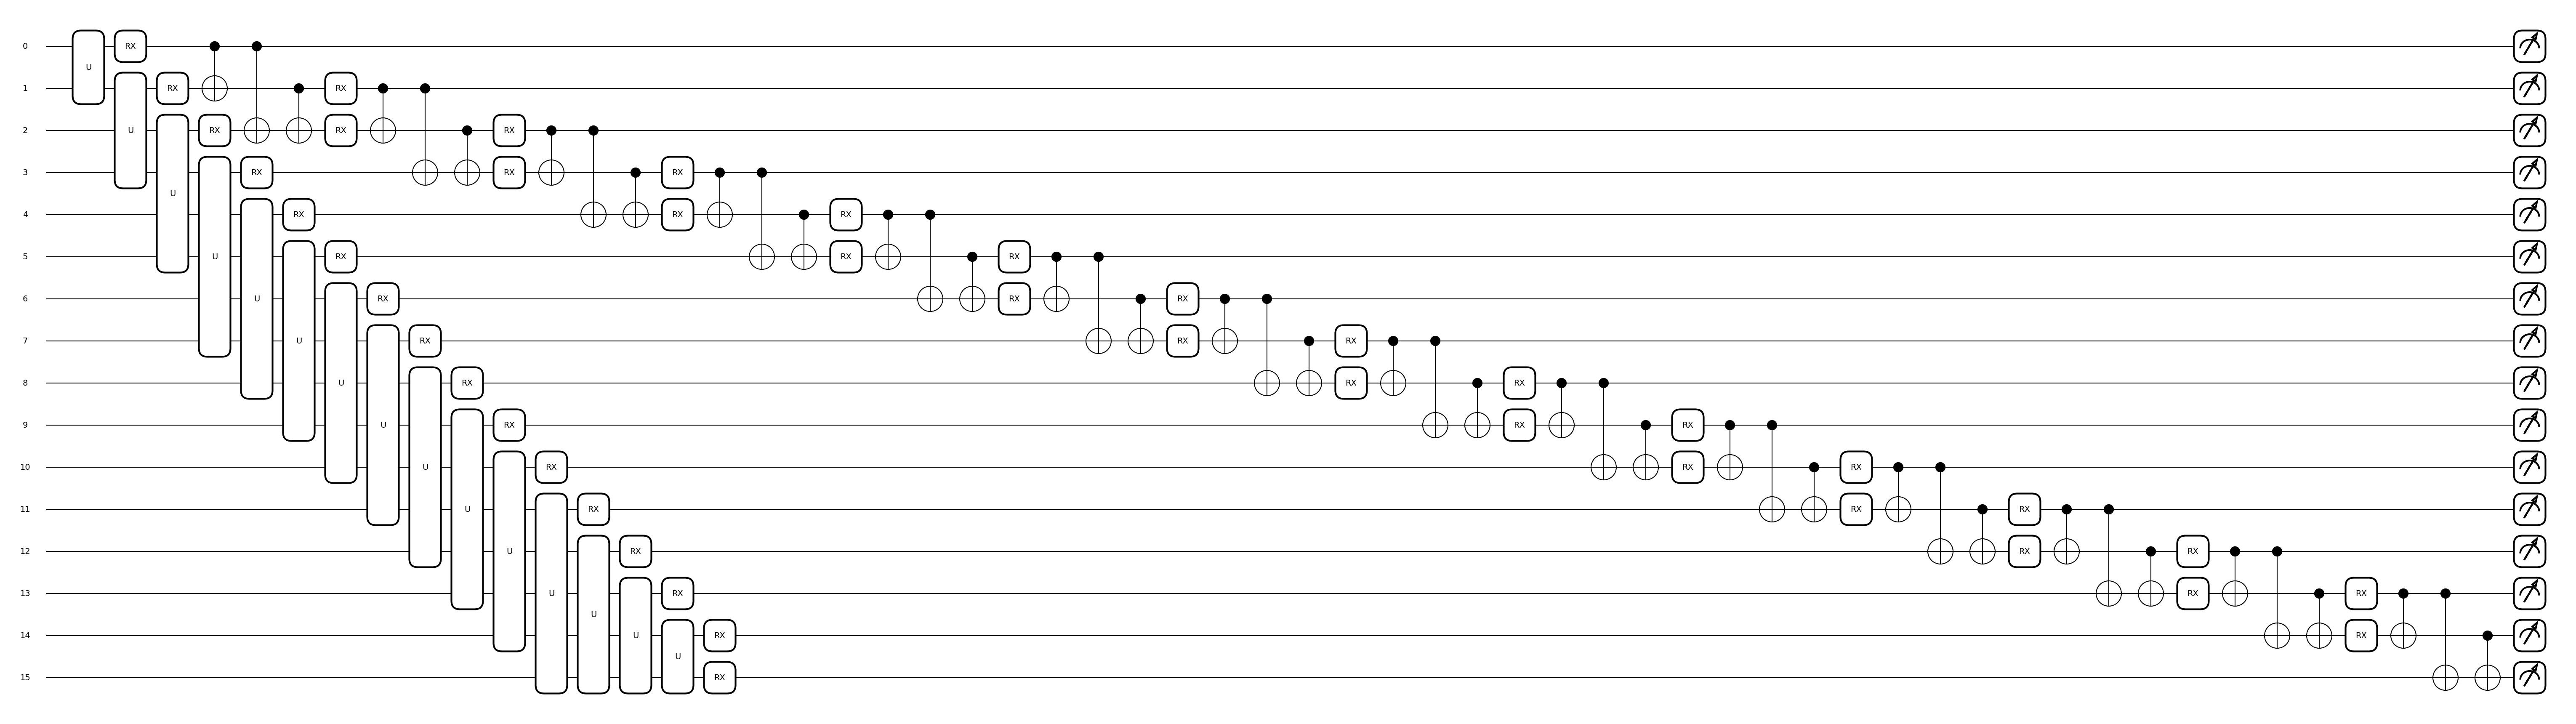

In [36]:
qml.drawer.draw_mpl(pqc_circuit)(weights)

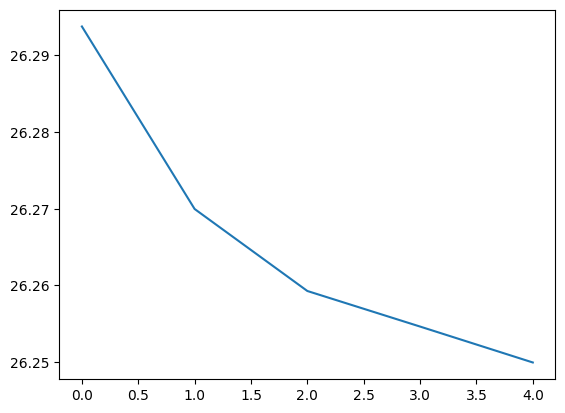

In [13]:
plt.plot(loss_track)

NameError: name 'numx' is not defined

In [11]:
import itertools
import numpy as np

def bars_and_stripes(rows, cols):
    
    data = [] 
    
    for h in itertools.product([0,1], repeat=cols):
        pic = np.repeat([h], rows, 0)
        data.append(pic.ravel().tolist())
          
    for h in itertools.product([0,1], repeat=rows):
        pic = np.repeat([h], cols, 1)
        data.append(pic.ravel().tolist())
        
    data = np.unique(np.asarray(data), axis=0)
    for i in range(len(data)):
        for j in range(len(data[i])):
            if data[i][j] == 1:
                data[i][j] = True
            else:
                data[i][j] = False
    return data

In [31]:
data = bars_and_stripes(4,3)
data_shaped = []
for i in range(len(data)):
    print(data[i].shape)
    data_shaped.append(data[i].reshape(12,))
data_shaped = pnp.array(data_shaped)

(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)


In [97]:
l1 = pnp.random.normal(size=(11, 15), requires_grad=True)
l2 = np.random.normal(size=(11, 15), requires_grad=True)

l3_1 = np.random.normal(size=(11, 15), requires_grad=True)
l3_2= np.random.normal(size=(11, 15), requires_grad=True)
l3_3 = np.random.normal(size=(11, 15), requires_grad=True)
l3_4 = np.random.normal(size=(11, 15), requires_grad=True)
l3_5 = np.random.normal(size=(11, 15), requires_grad=True)
l3_6 = np.random.normal(size=(11, 15), requires_grad=True)

v = [l1,l2,l3_1,l3_2,l3_4,l3_5,l3_6]
v = jnp.array(v)

In [100]:
weights = jnp.array(pnp.random.normal(size=(88, 15), requires_grad=True))


In [129]:
wires = 12
dev = qml.device("default.qubit", wires=wires)
# weights = jnp.array(pnp.random.normal(size=(45, 1), requires_grad=True))

@qml.qnode(dev, interface="jax")
def random_initialized_circuit(weights):
    i = 0
    while i < 11:
        qml.SpecialUnitary(weights[i], wires=[i, i + 1])
        i += 1
    w = 0
    while i < 22:
        qml.SpecialUnitary(weights[i], wires=[w, w + 1])
        w += 1
        i += 1    
    
    print(i)
    for x in range(wires - 1):
        for j in range(x + 1, wires):
            qml.SpecialUnitary(weights[i], wires=[x, j])
            i += 1
    return qml.probs(wires=list(range(wires)))

@jax.jit
def loss(weights):
    probs = random_initialized_circuit(weights)
    return metrics.kl_divergence(probs, data_shaped)

n_its = 10000

loss_track = []
opt_exc = optax.adam(0.1)
opt_state = opt_exc.init(weights)
for it in range(n_its):
    grads = jax.grad(loss)(weights)
    updates, opt_state = opt_exc.update(grads, opt_state)

    weights = optax.apply_updates(weights, updates)
    loss_track.append(loss(weights))


22
22


KeyboardInterrupt: 

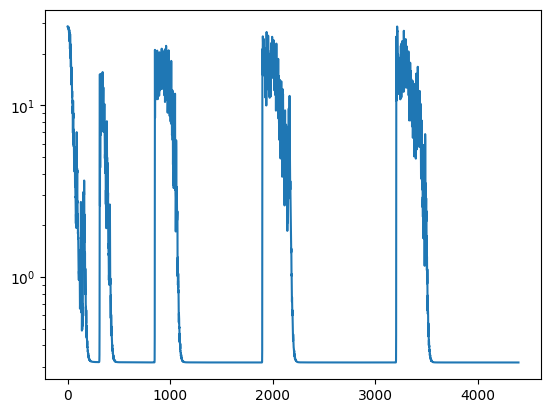

In [130]:
plt.plot(loss_track)
plt.yscale('log')

In [131]:
samples = random_initialized_circuit(weights)
metrics.plot_top_samples(samples)

22
Frequency : 1


ValueError: cannot reshape array of size 1 into shape (4,4)

(<Figure size 7100x1300 with 1 Axes>, <Axes: >)

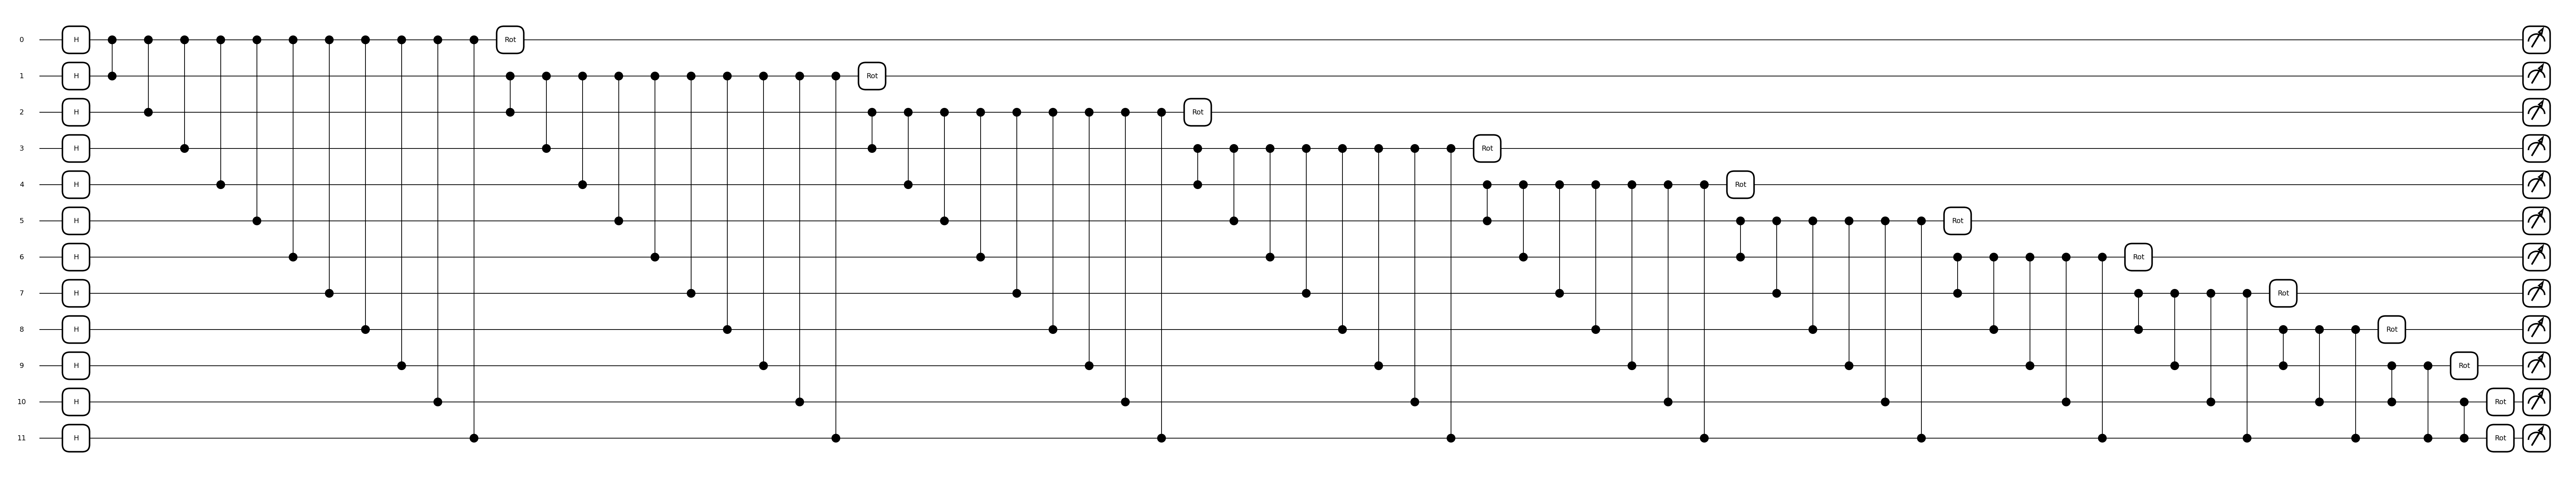

In [57]:
import pennylane as qml
from pennylane import numpy as np

n_qubits = 12

dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def circuit(params):
    # Apply Hadamard gates to all qubits
    for i in range(n_qubits):
        qml.Hadamard(wires=i)

    # Apply CZ gates between every pair of qubits
    for i in range(n_qubits):
        for j in range(i + 1, n_qubits):
            qml.CZ(wires=[i, j])

    # Apply rotation gates to all qubits
    for i in range(n_qubits):
        qml.Rot(*params[i], wires=i)

    # Measure all qubits
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

r = pnp.random.normal(size=(12,3))
